# Выбор локации для скважины

**Описание задачи**

Допустим, мы работаем в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Нам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Необходимо построить модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль, а затем проанализироваать возможную прибыль и риски техникой *Bootstrap.*

Условия задачи:

•	Для обучения модели подходит только линейная регрессия.

•	При разведке региона исследуется 500 точек, из которых с помощью машинного обучения выбирается 200 лучших для разработки.

•	Бюджет на разработку скважин в регионе — 10 млрд рублей.

•	При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.

•	После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них мы выбираем регион с наибольшей средней прибылью.


**Описание данных**

`id` — уникальный идентификатор скважины;

`f0`, `f1`, `f2` — три признака точек (неважно, что они означают, но сами признаки значимы);

`product` — объём запасов в скважине (тыс. баррелей).

## Загрузка и подготовка данных

In [1]:
# загружаем необходимые библиотеки, модели, инструменты
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as st

import sklearn
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor

In [2]:
RANDOM_STATE = 42
TEST_SIZE=0.25

In [3]:
# выгружаем данные геологоразведки по 3-м регионам и сохраняем в датафреймы
try:
    data_reg_1 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_0.csv', index_col='id')
    data_reg_2 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_1.csv', index_col='id')
    data_reg_3 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_2.csv', index_col='id')
except:
    data_reg_1 = pd.read_csv('/datasets/geo_data_0.csv', index_col='id')
    data_reg_2 = pd.read_csv('/datasets/geo_data_1.csv', index_col='id')
    data_reg_3 = pd.read_csv('/datasets/geo_data_2.csv', index_col='id')

In [4]:
# выводим общую информацию и первые строки по первому региону
data_reg_1.info()
data_reg_1.head()

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, txEyH to 1CWhH
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   f0       100000 non-null  float64
 1   f1       100000 non-null  float64
 2   f2       100000 non-null  float64
 3   product  100000 non-null  float64
dtypes: float64(4)
memory usage: 3.8+ MB


,f0,f1,f2,product
id,,,,
txEyH,0.705745,-0.497823,1.221170,105.280062
2acmU,1.334711,-0.340164,4.365080,73.037750
409Wp,1.022732,0.151990,1.419926,85.265647
iJLyR,-0.032172,0.139033,2.978566,168.620776
Xdl7t,1.988431,0.155413,4.751769,154.036647


In [5]:
# выводим общую информацию и первые строки по второму региону
data_reg_2.info()
data_reg_2.head()

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, kBEdx to relB0
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   f0       100000 non-null  float64
 1   f1       100000 non-null  float64
 2   f2       100000 non-null  float64
 3   product  100000 non-null  float64
dtypes: float64(4)
memory usage: 3.8+ MB


,f0,f1,f2,product
id,,,,
kBEdx,-15.001348,-8.276000,-0.005876,3.179103
62mP7,14.272088,-3.475083,0.999183,26.953261
vyE1P,6.263187,-5.948386,5.001160,134.766305
KcrkZ,-13.081196,-11.506057,4.999415,137.945408
AHL4O,12.702195,-8.147433,5.004363,134.766305


In [6]:
# выводим общую информацию и первые строки по третьему региону
data_reg_3.info()
data_reg_3.head()

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, fwXo0 to V9kWn
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   f0       100000 non-null  float64
 1   f1       100000 non-null  float64
 2   f2       100000 non-null  float64
 3   product  100000 non-null  float64
dtypes: float64(4)
memory usage: 3.8+ MB


,f0,f1,f2,product
id,,,,
fwXo0,-1.146987,0.963328,-0.828965,27.758673
WJtFt,0.262778,0.269839,-2.530187,56.069697
ovLUW,0.194587,0.289035,-5.586433,62.871910
q6cA6,2.236060,-0.553760,0.930038,114.572842
WPMUX,-0.515993,1.716266,5.899011,149.600746


In [7]:
# проверяем на наличие явных дубликатов
data_reg_1.duplicated().sum()

0

In [8]:
# проверяем на наличие явных дубликатов
data_reg_2.duplicated().sum()

0

In [9]:
# проверяем на наличие явных дубликатов
data_reg_3.duplicated().sum()

0

In [10]:
# создаем функцию для построения графиков для количественных признаков
def quant_feature(dataframe, feature, name, bins):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,5))
    fig.suptitle(name, fontsize=15)
    
    # построим диаграмму размаха
    sns.set_style("whitegrid")
    sns.boxplot(ax=axes[0], data = dataframe, y = feature)
    axes[0].set_title(f'Диаграмма размаха для признака: {feature}')
    axes[0].set_ylabel(f'{feature}')
    
    # строим гистрограмму
    sns.histplot(ax=axes[1], data=dataframe[feature], bins=bins)
    axes[1].set_title(f'Распределение значений признака: {feature}')
    axes[1].set_xlabel(f'{feature}')
    axes[1].set_ylabel('Частоты')
    plt.show()

In [11]:
# выводим описательную статистику по входным и целевому признакам первого региона
data_reg_1.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


In [12]:
# выводим описательную статистику по входным и целевому признакам второго региона
data_reg_2.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


In [13]:
# выводим описательную статистику по входным и целевому признакам третьего региона
data_reg_3.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


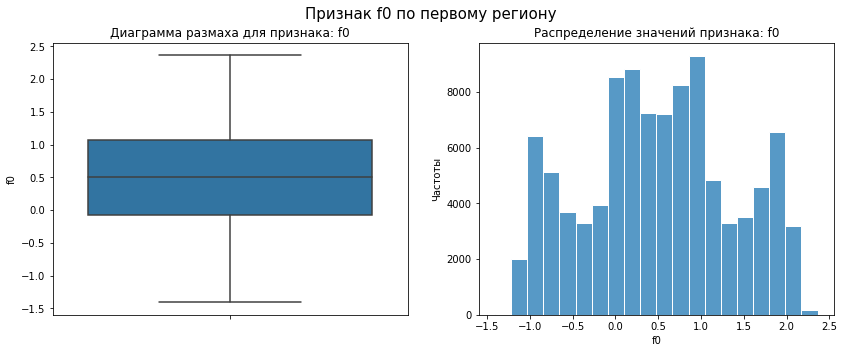

In [14]:
# выводим графики для признака 'f0' по первому региону
quant_feature(dataframe=data_reg_1, feature='f0',
              name='Признак f0 по первому региону', bins=20)

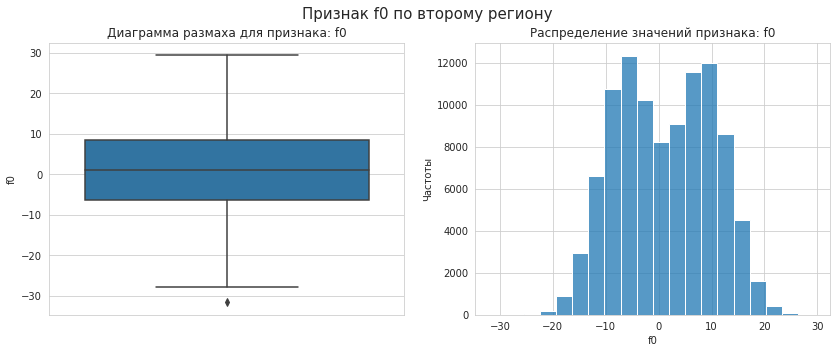

In [15]:
# выводим графики для признака 'f0' по второму региону
quant_feature(dataframe=data_reg_2, feature='f0',
              name='Признак f0 по второму региону', bins=20)

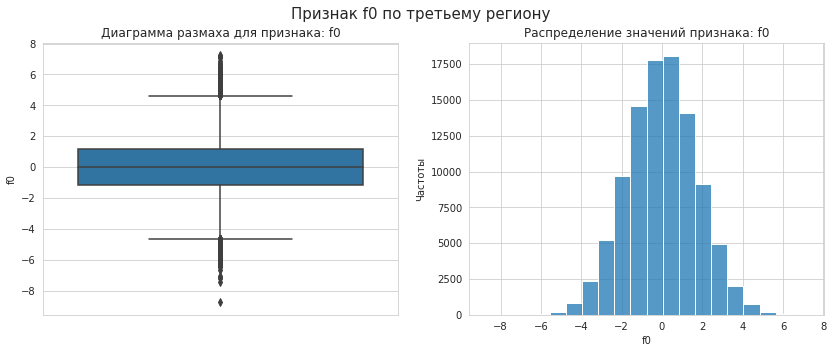

In [16]:
# выводим графики для признака 'f0' по третьему региону
quant_feature(dataframe=data_reg_3, feature='f0',
              name='Признак f0 по третьему региону', bins=20)

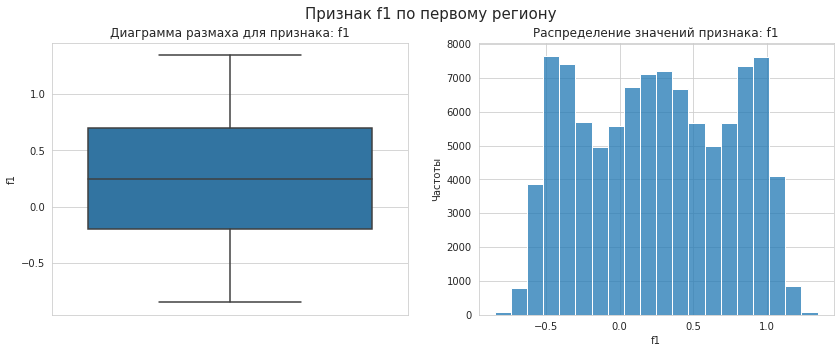

In [17]:
# выводим графики для признака 'f1' по первому региону
quant_feature(dataframe=data_reg_1, feature='f1',
              name='Признак f1 по первому региону', bins=20)

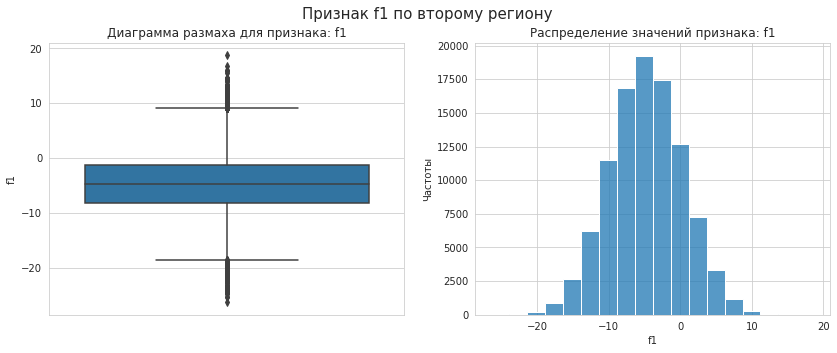

In [18]:
# выводим графики для признака 'f1' по второму региону
quant_feature(dataframe=data_reg_2, feature='f1',
              name='Признак f1 по второму региону', bins=18)

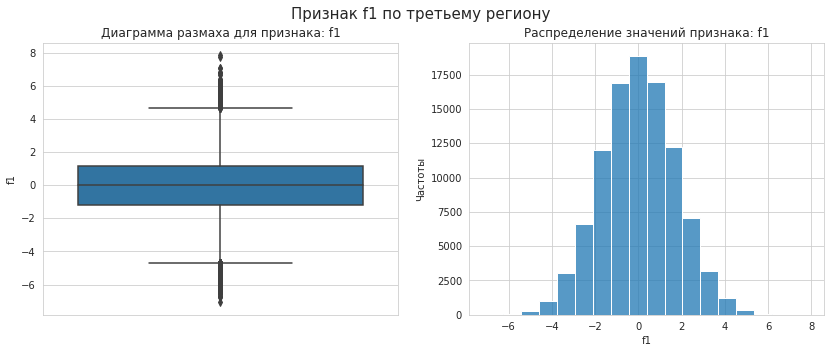

In [19]:
# выводим графики для признака 'f1' по третьему региону
quant_feature(dataframe=data_reg_3, feature='f1',
              name='Признак f1 по третьему региону', bins=18)

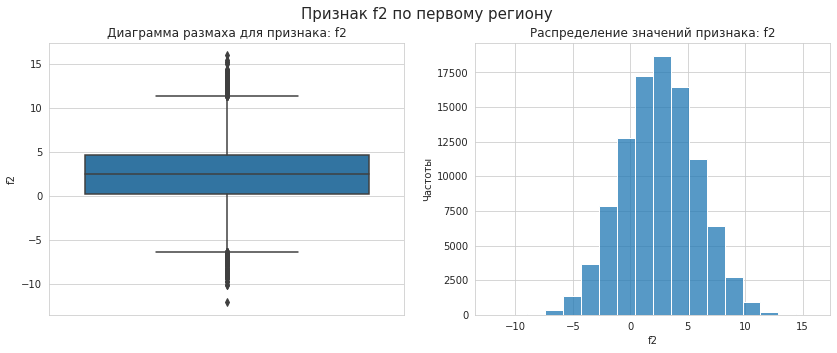

In [20]:
# выводим графики для признака 'f2' по первому региону
quant_feature(dataframe=data_reg_1, feature='f2',
              name='Признак f2 по первому региону', bins=18)

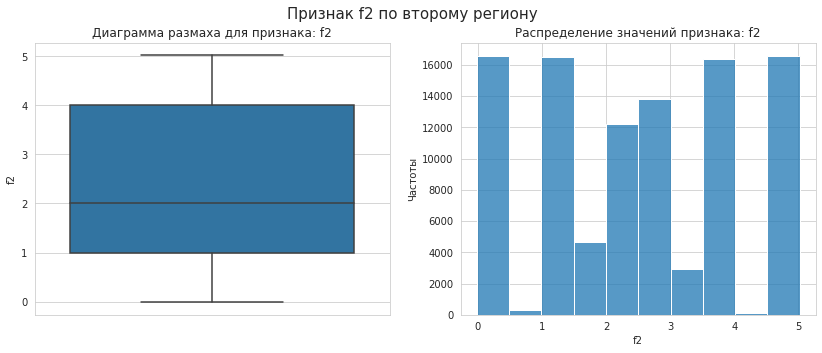

In [21]:
# выводим графики для признака 'f2' по второму региону
quant_feature(dataframe=data_reg_2, feature='f2',
              name='Признак f2 по второму региону', bins=10)

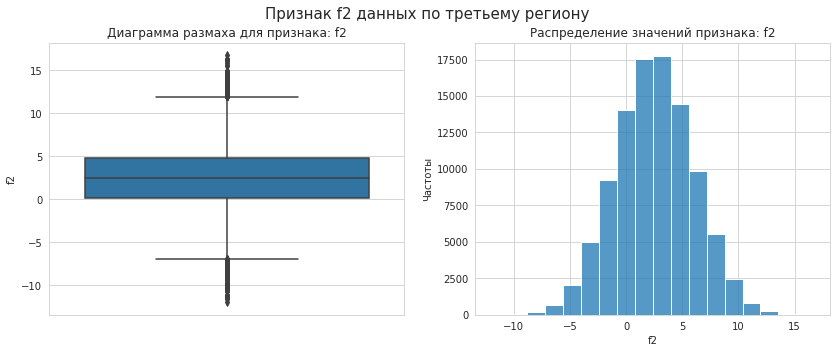

In [22]:
# выводим графики для признака 'f2' по третьему региону
quant_feature(dataframe=data_reg_3, feature='f2',
              name='Признак f2 данных по третьему региону', bins=18)

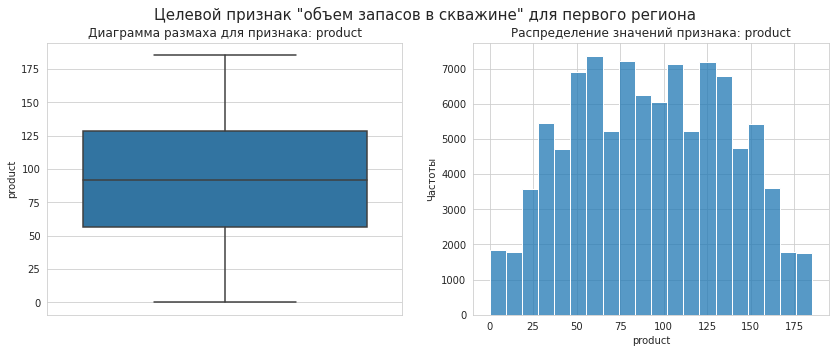

In [23]:
# выводим графики для целевого признака 'product' по первому региону
quant_feature(dataframe=data_reg_1, feature='product',
              name='Целевой признак "объем запасов в скважине" для первого региона', bins=20)

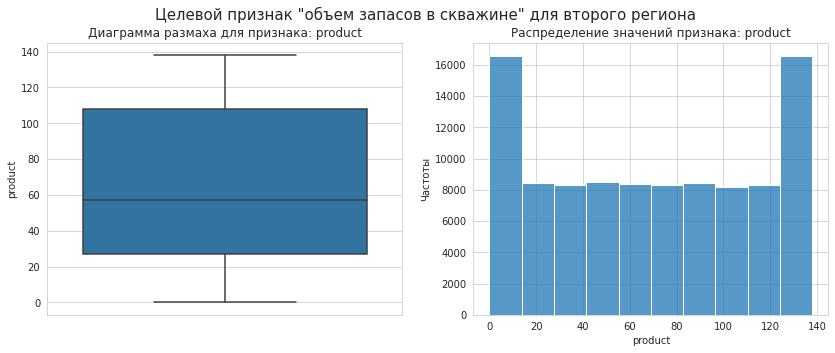

In [24]:
# выводим графики для целевого признака 'product' по второму региону
quant_feature(dataframe=data_reg_2, feature='product',
              name='Целевой признак "объем запасов в скважине" для второго региона', bins=10)

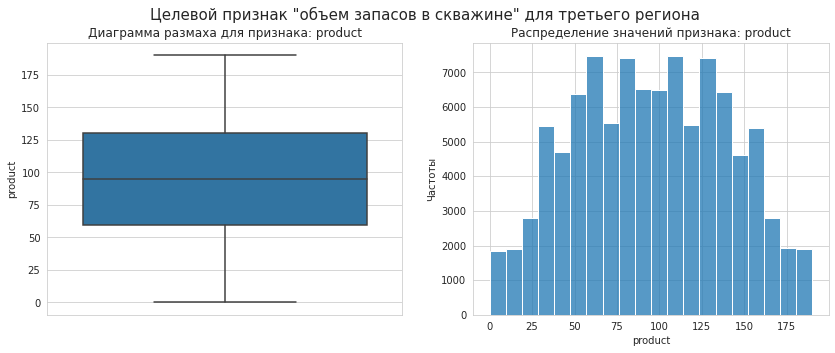

In [25]:
# выводим графики для целевого признака 'product' по третьему региону
quant_feature(dataframe=data_reg_3, feature='product',
              name='Целевой признак "объем запасов в скважине" для третьего региона', bins=20)

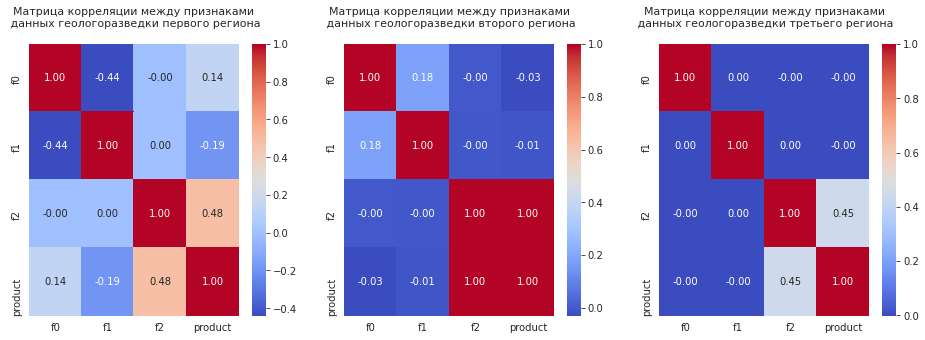

In [26]:
# выводим корреляционные матрицы для всех признаков по трём регионам
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16,5))
# для первого региона    
sns.heatmap(ax=axes[0], data=data_reg_1.corr('pearson'), annot=True, fmt='.2f', cmap='coolwarm')
axes[0].set_title('Матрица корреляции между признаками\n данных геологоразведки первого региона\n',
                  fontsize=11)
# для второго региона
sns.heatmap(ax=axes[1], data=data_reg_2.corr('pearson'), annot=True, fmt='.2f', cmap='coolwarm')
axes[1].set_title('Матрица корреляции между признаками\n данных геологоразведки второго региона\n',
                  fontsize=11)
# для третьего региона
sns.heatmap(ax=axes[2], data=data_reg_3.corr('pearson'), annot=True, fmt='.2f', cmap='coolwarm')
axes[2].set_title('Матрица корреляции между признаками\n данных геологоразведки третьего региона\n',
                  fontsize=11)
plt.show()


**Выводы:**

Мы выгрузили данные по 3-м регионам и сохранили их в 3-х разных датафреймах, использовав значения столбцца 'id' в качестве индекса. Мы вывели общую информацию и первые строки датафреймов, убедились, что в данных нет пропусков и что тип данных для всех столбцов задан правильно. После этого мы проверили наличие явных дубликатов в 3-х датафреймах, дубликатов в данных не обнаружено. После подготовки данных мы также провели исследовательский анализ данных. Мы вывели описательную статистику по входным и целевому признакам и построили для каждого признака диаграмму размаха и гистограмму, т.к. все данные у нас представляют собой непрерывные количественные величины. Мы видим незначительные выбросы по признакам 'f0' и 'f1' для второго и третьего регионам, по признаку 'f2' для первого и тертьего регионам. Эти выбросы не являются аномалиями и не должны сказаться на качестве прогнозной модели. Признак 'f0' имеет нормальное распределение по третьему региону, признак 'f1' нормально распределен по второму и тертьему региону, для признака 'f2' наблюдается нормальное распределение по первому и третьему региону. Распределение целевого признака 'product' отличается от нормального для всех регионов. 

В заключении мы провели корееляционный анализ для всех  входных и целевого признаков, которые планируем использовать в моделировании. Для вывода корреляционной матрицы для данных по каждому региону мы использовали коэффициент корреляции Пирсона, с помощью которого можно оценивать линейные взаимосвязи (посольку мы будем строить прогнозв по модели линейной регрессии). Для первого региона мы наблюдаем умеренную свзь целевого признака с признаком 'f2' (коэффициент 0.48) и слабую корреляцию с признаками 'f0' и 'f1'. По второму регону мы видим очень сильную корреляционную связь целевого признака с признаком 'f2' (коэффициент равен 1) и очень слабую корреляцию между целевым признаком и признаками 'f0' и 'f1' (коэффициенты близки к 0). По третьему регону мы видим умеренную корреляционную связь целевого признака с признаком 'f2' (коэффициент равен 0.45) и очень слабую корреляцию между целевым признаком и признаками  'f0' и 'f1' (коэффициенты практически равны 0). Для каждого из 3-х регионов мы видим, что мультиколлениарность между входными признаками отсутствует.

## Обучение и проверка модели

In [27]:
# объединяем датафреймы по 3-м регионам в список для работы в цикле
list_of_regions = [data_reg_1, data_reg_2, data_reg_3]

In [28]:
# чтобы избежать копирования при выполнении вычислений по каждому региону будем выполнять все шаги через цикл
for i, region in enumerate(list_of_regions):
    # определяем входные и целевой признаки
    X = region.drop('product', axis=1)
    y = region['product']
    # разделяем данные на тренировочную и тестовую выборку
    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = TEST_SIZE,
                                                    random_state = RANDOM_STATE)
    # применяем модель линейной регресии для прогноза значений запаса сырья на тестовой выборке, считаем среднеквадратичную ошибку
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = mean_squared_error(y_test, y_pred, squared=False)   
    print(f'Средний запас предсказанного сырья для {i+1}-го региона:', round(y_pred.mean(), 2))
    print(f'Среднеквадратичная ошибка модели для {i+1}-го региона:', round(rmse, 2))
    print('  ')

Средний запас предсказанного сырья для 1-го региона: 92.4
Среднеквадратичная ошибка модели для 1-го региона: 37.76
  
Средний запас предсказанного сырья для 2-го региона: 68.71
Среднеквадратичная ошибка модели для 2-го региона: 0.89
  
Средний запас предсказанного сырья для 3-го региона: 94.77
Среднеквадратичная ошибка модели для 3-го региона: 40.15
  


**Мы видим, что модель для первого и третьего регионов имеет сравнительно низкую точность. Попроубем добавить полиномизацию входных признаков для улучшения модели.**

In [30]:
for i, region in enumerate(list_of_regions):
    # определяем входные и целевой признаки
    X = region.drop('product', axis=1)
    y = region['product']
    # разделяем данные на тренировочную и тестовую выборку
    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = TEST_SIZE,
                                                    random_state = RANDOM_STATE)
    # применяем модель линейной регресии для прогноза значений запаса сырья на тестовой выборке, считаем среднеквадратичную ошибку
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    if rmse > 37:
        # применяем полиномизацию признаков
        poly_features = PolynomialFeatures(degree=4)
        X_train = poly_features.fit_transform(X_train)
        X_test = poly_features.transform(X_test)
        # обучаем и применяем модель линейной регрессии к трансформированным признакам для прогноза целевого признака по тестовой выборке
        # считаем среднеквадратичную ошибку
        model.fit(X_train, y_train)
        y_pred_poly = model.predict(X_test)
        rmse = mean_squared_error(y_test, y_pred_poly, squared=False)
        X = poly_features.fit_transform(X)
    print("\033[1m"+f'Средний запас предсказанного сырья для {i+1}-го региона:',
          round(y_pred.mean(), 2))
    print(f'Среднеквадратичная ошибка модели для {i+1}-го региона:', round(rmse, 2))
    
    # проверим модель на адекватность, сравнив качество её предсказаний с качеством предсказаний модели DummyRegressor(strategy="median")
    dummy_model = DummyRegressor(strategy="median")
    dummy_model.fit(X_train, y_train)
    y_pred_dummy = dummy_model.predict(X_test)
    rmse_dummy = mean_squared_error(y_test, y_pred_dummy, squared=False)
    print(f'Значение метрики RMSE для модели DummyRegressor на тестовой выборке по {i+1}-му региону:',
          round(rmse_dummy, 2))
    print(' '+"\033[0;0m")
    
    # используем обученную ранее модель для прогноза целевого признака для полной выборки по региону и добавляем полученные прогнозные значения в датафрейм
    y_pred_full = model.predict(X)
    region = region.reset_index()
    region['forecast_product'] = pd.Series(y_pred_full)
    list_of_regions[i] = region

Средний запас предсказанного сырья для 1-го региона: 92.4
Среднеквадратичная ошибка модели для 1-го региона: 37.33
Значение метрики RMSE для модели DummyRegressor на тестовой выборке по 1-му региону: 44.28
 
Средний запас предсказанного сырья для 2-го региона: 68.71
Среднеквадратичная ошибка модели для 2-го региона: 0.89
Значение метрики RMSE для модели DummyRegressor на тестовой выборке по 2-му региону: 47.4
 
Средний запас предсказанного сырья для 3-го региона: 94.77
Среднеквадратичная ошибка модели для 3-го региона: 38.29
Значение метрики RMSE для модели DummyRegressor на тестовой выборке по 3-му региону: 44.78
 


In [31]:
data_reg_1 = list_of_regions[0]
data_reg_2 = list_of_regions[1]
data_reg_3 = list_of_regions[2]
print("\033[1m"+'Датафрейм с прогнозными значениями запасов нефти по первому региону:'+"\033[0;0m")
display(data_reg_1)
print("\033[1m"+'Датафрейм с прогнозными значениями запасов нефти по второму региону:'+"\033[0;0m")
display(data_reg_2)
print("\033[1m"+'Датафрейм с прогнозными значениями запасов нефти по третьему региону:'+"\033[0;0m")
display(data_reg_3)

Датафрейм с прогнозными значениями запасов нефти по первому региону:


,id,f0,f1,f2,product,forecast_product
0,txEyH,0.705745,-0.497823,1.221170,105.280062,94.095686
1,2acmU,1.334711,-0.340164,4.365080,73.037750,114.672102
2,409Wp,1.022732,0.151990,1.419926,85.265647,80.876105
3,iJLyR,-0.032172,0.139033,2.978566,168.620776,104.368563
4,Xdl7t,1.988431,0.155413,4.751769,154.036647,121.024047
...,...,...,...,...,...,...
99995,DLsed,0.971957,0.370953,6.075346,110.744026,108.660132
99996,QKivN,1.392429,-0.382606,1.273912,122.346843,93.390128
99997,3rnvd,1.029585,0.018787,-1.348308,64.375443,65.696877
99998,7kl59,0.998163,-0.528582,1.583869,74.040764,96.298342


Датафрейм с прогнозными значениями запасов нефти по второму региону:


,id,f0,f1,f2,product,forecast_product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103,3.842537
1,62mP7,14.272088,-3.475083,0.999183,26.953261,26.585852
2,vyE1P,6.263187,-5.948386,5.001160,134.766305,135.665780
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408,138.542435
4,AHL4O,12.702195,-8.147433,5.004363,134.766305,134.866656
...,...,...,...,...,...,...
99995,QywKC,9.535637,-6.878139,1.998296,53.906522,54.275193
99996,ptvty,-10.160631,-12.558096,5.005581,137.945408,138.308191
99997,09gWa,-7.378891,-3.084104,4.998651,137.945408,137.512981
99998,rqwUm,0.665714,-6.152593,1.000146,30.132364,28.641590


Датафрейм с прогнозными значениями запасов нефти по третьему региону:


,id,f0,f1,f2,product,forecast_product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673,65.238760
1,WJtFt,0.262778,0.269839,-2.530187,56.069697,48.429616
2,ovLUW,0.194587,0.289035,-5.586433,62.871910,36.809170
3,q6cA6,2.236060,-0.553760,0.930038,114.572842,85.520888
4,WPMUX,-0.515993,1.716266,5.899011,149.600746,111.889043
...,...,...,...,...,...,...
99995,4GxBu,-1.777037,1.125220,6.263374,172.327046,117.306748
99996,YKFjq,-1.261523,-0.894828,2.524545,138.748846,87.334604
99997,tKPY3,-1.199934,-2.957637,5.219411,157.080080,125.391717
99998,nmxp2,-2.419896,2.417221,-5.548444,51.795253,69.732437


**Выводы:** Мы последовательно обучили и применили модели линейной регрессии для каждого из 3-х регионов. Мы не применяли мастабирования данных, так как на предыдущем шаге убедилиись, что значения всех признаков представлены в соспоставтимых шкалах. По первому и третьему регионам прогнозные модели дали нам неоень качественные прогнозы, при средних прогнозных значениях по объему сырья в скважине в пределах 92.4 - 94.8 тысяч баррелей средняя квадратичная ошибка (rmse)  составила 37.76 и 40.15. Поэтому мы решили попробовать применить полиномизацию входных признаков (использовали степень полиномизации 4). Полиномизация позволила несколько улучшить прогностическое качество модели, особенно для третьего региона. После полиномизации входных признаков средняя квадратичная ошибка для первого региона составила 37.33, а для третьего региона - 38.29. Поэтоу для дальнейшей работы с данными по первому и третьему регионам мы используем прогнозы, полученные на моделях линейной регрессии с применением полниномизации входных признаков. При выбранной степени полиномизации и заданном кол-ве данных модели работают сравнительно быстро. По второму региону мы также применили модель линейной регресии для прогнозирования объема сырья в скважинах. По второму региону мы получили очень хорошие прогнозы с низкой средней квадратичной ошибкой 0.89. Ранее по корреляционной матрице мы увидели, что целевой признак имеет очень сильную прямую связь с признаком 'f2', это во многом объясняет высокую точность модели. При этом по второму региону мы получили средний объем запаса сырья в скважине заметно меньше, чем по первому и второму региону - 68.7 тысяч баррелей. Мы добавили в датафреймы по регионам прогнозные значения запасов сырья по каждой скважине, полученные на основе выбранной и обученной на тренировочной выборке лучшей модели. 

Мы проверили получивившиеся модели для трёх регионов на адекватность, сравнив качество предсказаний модели с качеством предсказаний модели DummyRegressor с настройкой вывода медианных значений в качестве предсказаний. Мы видим, что у полученных моделей для прогноза значение метрики RMSE на тестовой выборке лучше, чем у модели DummyRegressor. Значит принятые для прогноза модели адекватная.

## Подготовка к расчёту прибыли

In [32]:
# необходимо выбрать 200 скважин для разработки 
N_WELLS = 200
# прибыль, которую можно получить с 1 тысячи баррелей запасов нефти
WELL_REVENUE = 450000
# бюджет на разработку скважин в регионе — 10 млрд рублей
BUDGET = 10000000000

In [33]:
# считаем достаточный объем сырья в одной скважине для безубыточной разработки 
breakeven_product = BUDGET/(N_WELLS*WELL_REVENUE)
print('Достаточный объём сырья для безубыточной разработки новой скважины, тысяч баррелей:',
      round(breakeven_product, 2))

Достаточный объём сырья для безубыточной разработки новой скважины, тысяч баррелей: 111.11


In [34]:
# для сравнения выводим средние запасы сырья в одной скважине по регионам
print('Средний запас нефти в скважине по первому региону, тысяч баррелей',
      round(data_reg_1['product'].mean(), 2))
print('Средний запас нефти в скважине по второму региону, тысяч баррелей',
      round(data_reg_2['product'].mean(), 2))
print('Средний запас нефти в скважине по третьему региону, тысяч баррелей',
      round(data_reg_3['product'].mean(), 2))

Средний запас нефти в скважине по первому региону, тысяч баррелей 92.5
Средний запас нефти в скважине по второму региону, тысяч баррелей 68.83
Средний запас нефти в скважине по третьему региону, тысяч баррелей 95.0


**Выводы:**

Мы сохранили константные значения, которые будем использовать для расчёта прибыли: кол-во скважин для разработки N_WELLS равно 200, прибыль с одной тясячи баррелей нефти в скважине WELL_REVENUE равна 450 000, бюджет на разработку скважин в регионе BUDGET равен 10 000 000 000. Данные по объему нефти в скважине и прогнозному значению объема нефти в скважине мы будем использовать разные по каждому региону на основе выборок, сформированных техникой Bootstrep, мы задим их непосредственно на этапе подсчёта прибыли по каждому региону. На основе заданных константных значений мы посчитали достаточный объём сырья для безубыточной разработки новой скважины: 111.11 тысяч баррелей нефти. Т.е. для безубыточной разработки нужно выбирать скважины с объёмом нефти не менее 111.11 тысяч баррелей. Затем мы сравнили полученное пороговое значение для безубыточной разработки со средними запасами нефти в скважине по каждому региону: 92.5 тысяч баррелей по первому региону, 68.8 тысяч баррелей по второму региону, 95 тысяч баррелей по третьему региону. Получается, что средние значения запасов нефти в скважине в каждом регионе ниже достатосчного уровня объема сырья для безубыточной разработки. Таким образом на дальнейшем этапе выбора скважин для разработки неотрицательное значение прибыли можно получить при выборе скважин с запасами нефти не ниже 111.11 тысяч баррелей, иначе риски получения убытка возрастают.

## Функция для расчёта прибыли по  выбранным скважинам и предсказаниям модели

In [35]:
# функция для расчёта прибыли по выбранным скважинам и предсказаниям модели
# n - число скважин, выбранных для разработки 
# revenue - прибыль, которую можно получить с 1 тысячи баррелей запасов нефти
# budget - бюджет на разработку скважин в регионе
# product - объем запасов сырья в одной скважине
# forecast - прогнозное значение запасов сырья в скважине

def region_profit (n, revenue, budget, product, forecast):
    forecast_sorted = forecast.sort_values(ascending=False)
    select_product = product[forecast_sorted.index][:n]
    return revenue*(select_product.sum()) - budget

## Расчёт рисков и прибыли для каждого региона

In [36]:
# функция для построения гистограммы
def profit_distribution(data, num):
    plt.figure(figsize = (6, 5))
    sns.histplot(data, bins=20)
    plt.title(f'Распределение прибыли от 200 скважин {num}-го региона')
    plt.ylabel('Частоты')
    plt.show()

In [37]:
# создаем лист из датафреймов по 3-м регионам
list_of_regions = [data_reg_1, data_reg_2, data_reg_3]
state = np.random.RandomState(123)

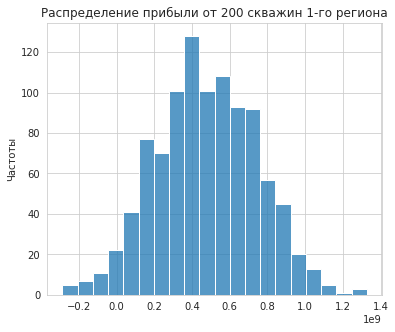

Средняя прибыль для 1-го региона: 476541463.23
95%-й доверительный интервал для 1-го региона: [-31172838.54, 997354515.63]
Риск убытков от разработки скважин 1-го региона, в процентах: 3.40%


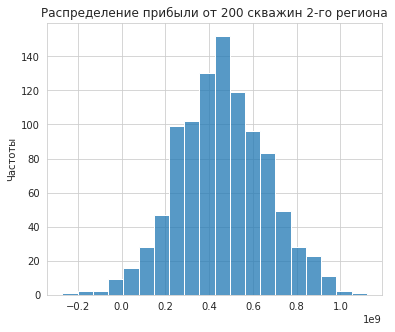

Средняя прибыль для 2-го региона: 458626896.46
95%-й доверительный интервал для 2-го региона: [64598541.84, 877996644.91]
Риск убытков от разработки скважин 2-го региона, в процентах: 1.30%


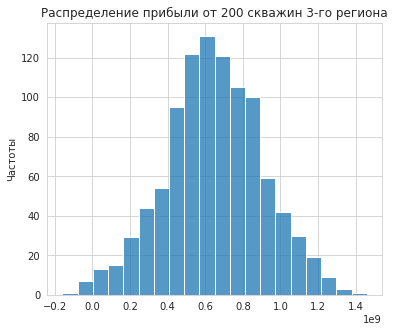

Средняя прибыль для 3-го региона: 646834743.4
95%-й доверительный интервал для 3-го региона: [105893934.04, 1169049657.67]
Риск убытков от разработки скважин 3-го региона, в процентах: 0.80%


In [38]:
# чтобы избежать копирования при выполнении вычислений по каждому региону будем выполнять все шаги через цикл
for i, region in enumerate(list_of_regions):
    # записываем в переменные реальные и прогнозные значения объема запасов сырья для скважин первого региона
    product = region['product']
    forecast_product = region['forecast_product']
    reg=i+1
    
    # применим технику Bootstrap для 1000 выборок, чтобы найти распределение прибыли
    profit = []
    for i in range(1000):
        product_subsample = product.sample(n=500, random_state=state, replace=True)
        forecast_subsample = forecast_product[product_subsample.index]
        res = region_profit(n=N_WELLS, revenue=WELL_REVENUE, budget=BUDGET,
        product=product_subsample, forecast=forecast_subsample) 
        profit.append(res)

    profit = pd.Series(profit)

    # построим график распределения прибыли от 200 скважин для 1000 выборок
    profit_distribution(data=profit, num=reg)
    
    # выводим среднюю прибыль и 95% доверительный интервал для первого региона
    print("\033[1m"+f'Средняя прибыль для {reg}-го региона:', round(profit.mean(), 2))
    lower = profit.quantile(0.025)
    upper = profit.quantile(0.975)
    confidence_interval = [round(lower, 2), round(upper, 2)]
    print(f'95%-й доверительный интервал для {reg}-го региона:', confidence_interval)
    
    # считаем риск убытков как долю случаев с отрицательной прибылью
    risk_of_loss = (profit<0).mean()
    print(f'Риск убытков от разработки скважин {reg}-го региона, в процентах:',
          f"{risk_of_loss:.2%}"+"\033[0;0m")

**Выводы:**

На последнем шаге мы последовательно сделали расчёт прибыли, 95% доверительного интервала и риска убытков для 3-х регионов. Сначала мы применили технику Bootstrap для создания 1000 подвыборок со значениями запасов нефти, произвольно выбранных из значений по всем скважинам региона. Каждая из подвыборок создается в цикле. В каждую подвыборку вошло по 500 значений запасов нефти в скважине, а также для каждого значения запаса нефти мы выбрали соответствующие прогнозные значения запасов нефти, отобранные по индексу запасов нефти. Затем мы применяем функцию для подсчёта прибыли, которую создали на предыдущем шаге. Функция сортирует значения прогнозных значений запасов нефти по убыванию, затем отбирает 200 верхних значений, т.е. наиболее высоких значений в подвыборке. Затем по индексам прогнозных значений сырья отбираются соответствующие значения реальных запасов сырья. По реальным значениям запасов нефти затем считается общая прибыль по выбранным скважинам в регионе: сумму запасов по выбранным скважинам мы умножаем на прибыль, которую можно получить с 1 тысячи баррелей запасов нефти (450 000), и вычитаем бюджет на разработку скважин в регионе (10 000 000 000). Мы добавляем значения прибыли для каждой подвыборки в единый список. Затем на основе списка мы строим гистограмму, которая показывает распределение прибыли для кажжого региона. Графики распределения прибыли по каждому региону, полученные на основе сформированных подвыборок, показывают распределение, которое можно считать нормальным. Помимо прибыли для каждого региона мы вывели 95% доверительный интервал и риск убытков. Для расчёта риска убытков мы  посчитали долю скважин с отрицательной прибылью.

Мы получили, что риски получения отрицательной прибыли на основе техники Bootstrep, полученных прогнозных значений запасов нефти в каждой скважине и примения функции для определения прибыли сравнительно невысокие - от 0.8 до 3.4%. По первому региону среднее значение прибыли около 476.5 млн. руб., а риск получения убытков 3.4%. Также для первого региона нижняя граница доверительного интервала имеет отрицательное значение. По другим регионам нижняя граница доверительного интервала выше 0, следовательно в первую очередь следует отказаться от добычи в первом регионе. По второму региону среднее значение прибыли около 458.6 млн. руб., а риск получения убытков 1.3%. По третьему региону мы получили среднее значение прибыли около 646.8 млн. руб., а риск получения убытков 0.8%.

Таким образом, для разработки мы предлагаем выбрать третий регион, т.к. по третьему региону мы получили максимальную из всех регионов прибыль, самую высокие нижнюю и верхнюю границы доверительного интервала и минимальное значение риска убытков. Значение риска убытков для третьего региона минимальная даже с учётом того, что модель прогноза запасов нефти по скважинам даёт самое высокое значение ошибки (по сравнению с моделями для двух других регионов).

## Чек-лист готовности проекта

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные подготовлены
- [x]  Выполнен шаг 2: модели обучены и проверены
    - [x]  Данные корректно разбиты на обучающую и валидационную выборки
    - [x]  Модели обучены, предсказания сделаны
    - [x]  Предсказания и правильные ответы на валидационной выборке сохранены
    - [x]  На экране напечатаны результаты
    - [x]  Сделаны выводы
- [x]  Выполнен шаг 3: проведена подготовка к расчёту прибыли
    - [x]  Для всех ключевых значений созданы константы Python
    - [x]  Посчитано минимальное среднее количество продукта в месторождениях региона, достаточное для разработки
    - [x]  По предыдущему пункту сделаны выводы
    - [x]  Написана функция расчёта прибыли
- [x]  Выполнен шаг 4: посчитаны риски и прибыль
    - [x]  Проведена процедура *Bootstrap*
    - [x]  Все параметры бутстрепа соответствуют условию
    - [x]  Найдены все нужные величины
    - [x]  Предложен регион для разработки месторождения
    - [x]  Выбор региона обоснован